In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.autograd import Variable
from collections import OrderedDict
import tensorflow as tf

2023-01-24 19:32:55.106301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("../../data/SynthCross_n1000_p2.csv")
df["z"] = df["z"].apply(lambda x: 1 if x=="A" else 0)

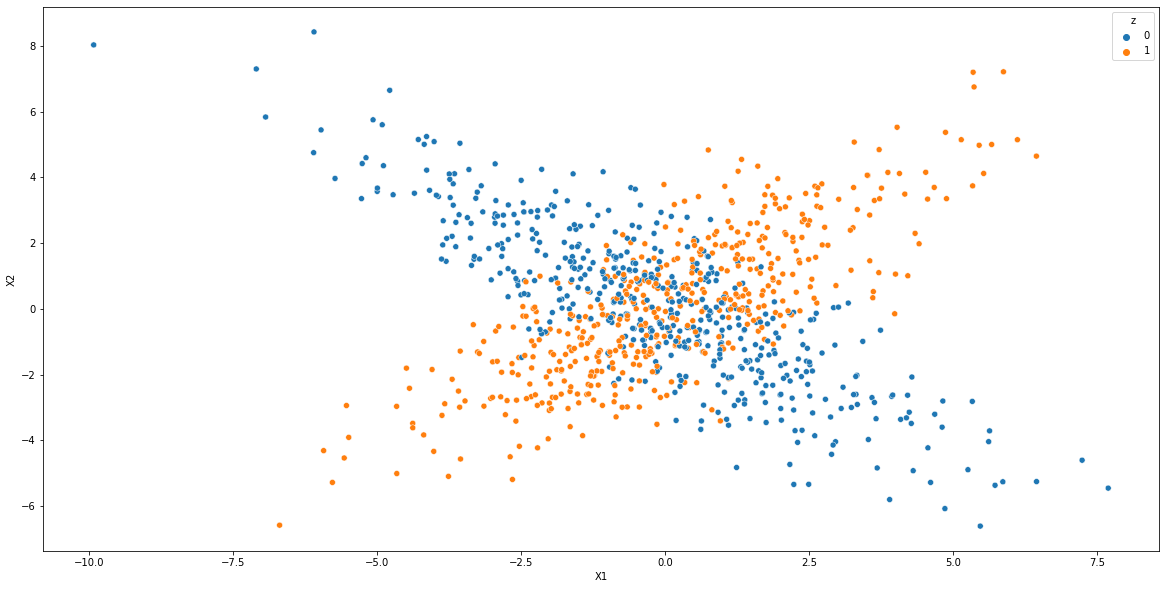

In [3]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=df, x="X1", y="X2", hue="z")
plt.show()

In [4]:
class MyDataset(torch.utils.data.Dataset):
 
    def __init__(self, x_train, y_train):
        x=x_train.values
        y=y_train.values

        self.X_train=torch.tensor(x,dtype=torch.float32)
        self.Y_train=torch.tensor(y,dtype=torch.float32)

    def __len__(self):
        return len(self.Y_train)
   
    def __getitem__(self,idx):
        return self.X_train[idx],self.Y_train[idx]

In [5]:
def KLD_loss(y_true, y_pred):
    kld = nn.KLDivLoss(reduction="batchmean", log_target=False)
    loss = kld(y_pred, y_true) + kld(1-y_pred, 1-y_true)
    return loss

In [6]:
class Simple_Neural_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Sequential(OrderedDict({
            'linear': nn.Linear(in_features=2, out_features=3),
            'relu': nn.ReLU(inplace=True),
        }))
        self.hidden_layer = nn.Linear(in_features=3, out_features=1)
        self.output_layer = nn.Sigmoid()
        self.losses = {}
        self.accuracies = {}
    
    def forward(self, x):
        y = self.input_layer(x)
        y = self.hidden_layer(y)
        y_pred = self.output_layer(y)
        return y_pred
    
    def __initiate_loss_and_accuracy_dicts(self, n_epochs):
        for i in range(n_epochs):
            self.losses[i] = 0
            self.accuracies[i] = 0
    
    def fit(self, x_train, y_train, epochs, learning_rate, verbose=True, soft=False):
        self.__initiate_loss_and_accuracy_dicts(n_epochs=epochs)
        myDs=MyDataset(x_train=x_train, y_train=y_train)
        train_loader=torch.utils.data.DataLoader(myDs,batch_size=10,shuffle=False)
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        for e in range(epochs):
            n_batches = len(train_loader)
            if verbose:
                print(f'Epoch {e+1}/{epochs}')
                pbar = tf.keras.utils.Progbar(target=n_batches)
            for idx, batch in enumerate(train_loader):
                x, y = batch
                optimizer.zero_grad()
                outputs = self(x)
                if not soft:
                    loss = nn.BCELoss()
                    loss_value = loss(outputs, y.reshape(-1, 1))
                else:
                    loss_value = KLD_loss(y.reshape(-1, 1), outputs)
                loss_value.backward()
                optimizer.step()
                if not soft:
                    accuracy = accuracy_score(
                        y_true=y,
                        y_pred=outputs.reshape(-1).detach().numpy().round()
                    )
                    self.accuracies[e] += accuracy
                self.losses[e] += loss_value.detach().numpy()
                curr_idx = idx+1
                if verbose:
                    pbar.update(
                        idx,
                        values=[
                            ("loss", loss_value.detach().numpy()),
                            ("accuracy", accuracy)
                        ]
                    )
            self.losses[e] = self.losses[e]/n_batches
            self.accuracies[e] = self.accuracies[e]/n_batches
            if verbose:
                pbar.update(n_batches, values=None) 
            
    def predict_probas(self, x, as_numpy=False, from_numpy=True):
        if from_numpy:
            x = torch.tensor(x,dtype=torch.float32)
        outputs = self(x)
        if as_numpy:
            outputs = outputs.detach().numpy()
        return outputs

In [7]:
def plot_decision_boundary(dataset, labels, model, steps=1000, color_map='Paired'):
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    print()
    xmin, xmax = dataset.to_numpy()[:, 0].min() - 1, dataset.to_numpy()[:, 0].max() + 1
    ymin, ymax = dataset.to_numpy()[:, 1].min() - 1, dataset.to_numpy()[:, 1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    model.eval()
    labels_predicted = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))

    # Plot decision boundary in region of interest
    labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted.detach().numpy()]
    z = np.array(labels_predicted).reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.2)
    
    return fig, ax

# Train calibration test split

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(df[["X1", "X2"]], df["z"], train_size=0.8)

In [9]:
X_train, X_calib, Y_train, Y_calib = train_test_split(X_train, Y_train, train_size=0.975)

In [10]:
trainset = pd.DataFrame(X_train, columns=["X1", "X2"])
trainset["z"] = Y_train
trainset.iloc[80:, trainset.columns.get_loc("z")] = np.NaN 

# First strategy : add the most probable label at each iteration

In [11]:
known_train = trainset.iloc[0:80]
unknow_train = trainset.iloc[80:]
known_train.shape, unknow_train.shape, X_calib.shape, X_test.shape

((80, 3), (700, 3), (20, 2), (200, 2))

In [12]:
class SelfLearning():
    def __init__(
        self,
        known_x_train,
        known_y_train,
        unknown_x_train,
        model_convergence_epochs 
    ):
        self.model_convergence_epochs = model_convergence_epochs
        self.model = Simple_Neural_Net()
        self.known_x_train = known_x_train
        self.known_y_train = known_y_train
        self.unknown_x_train = unknown_x_train
        
        self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.2)
        self.accuracies = []
    
    def learning(self, validation_x, validation_y, batch_adding=5):
        while len(self.unknown_x_train) >= batch_adding:
            self.unknown_x_train["y"] = self.model.predict_probas(self.unknown_x_train.to_numpy()).detach().numpy()
            self.unknown_x_train.sort_values("y", ascending=False, inplace=True)
            self.unknown_x_train["y"] = self.unknown_x_train["y"].apply(lambda x: 1 if x>0.5 else 0)
            self.known_x_train = pd.concat(
                [
                    self.known_x_train,
                    self.unknown_x_train.iloc[0:batch_adding][["X1", "X2"]],
                    self.unknown_x_train.iloc[-batch_adding:][["X1", "X2"]]
                ]
            )
            self.known_y_train = pd.concat(
                [
                    self.known_y_train,
                    self.unknown_x_train.iloc[0:batch_adding]["y"],
                    self.unknown_x_train.iloc[-batch_adding:]["y"]
                ]
            )
            self.unknown_x_train = self.unknown_x_train.iloc[batch_adding:-batch_adding][["X1", "X2"]]
            predictions = self.model.predict_probas(validation_x.to_numpy()).reshape(-1).detach().numpy().round()
            self.accuracies.append(accuracy_score(validation_y, predictions))
            self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.2, verbose=False)

In [13]:
test = SelfLearning(
    known_x_train=known_train[["X1", "X2"]],
    known_y_train=known_train["z"],
    unknown_x_train=unknow_train[["X1", "X2"]],
    model_convergence_epochs=20
)

Epoch 1/20
8/8 [==============================] - 0s 4ms/step - loss: 0.7102 - accuracy: 0.5500
Epoch 2/20
8/8 [==============================] - 0s 2ms/step - loss: 0.6612 - accuracy: 0.6125
Epoch 3/20
8/8 [==============================] - 0s 2ms/step - loss: 0.6404 - accuracy: 0.6250
Epoch 4/20
8/8 [==============================] - 0s 2ms/step - loss: 0.6309 - accuracy: 0.6125
Epoch 5/20
8/8 [==============================] - 0s 2ms/step - loss: 0.6243 - accuracy: 0.6500
Epoch 6/20
8/8 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.7000
Epoch 7/20
8/8 [==============================] - 0s 2ms/step - loss: 0.6126 - accuracy: 0.7250
Epoch 8/20
8/8 [==============================] - 0s 4ms/step - loss: 0.6046 - accuracy: 0.7375
Epoch 9/20
8/8 [==============================] - 0s 2ms/step - loss: 0.5939 - accuracy: 0.7375
Epoch 10/20
8/8 [==============================] - 0s 3ms/step - loss: 0.5774 - accuracy: 0.7375
Epoch 11/20
8/8 [======================

In [14]:
test.learning(validation_x=X_test, validation_y=Y_test)

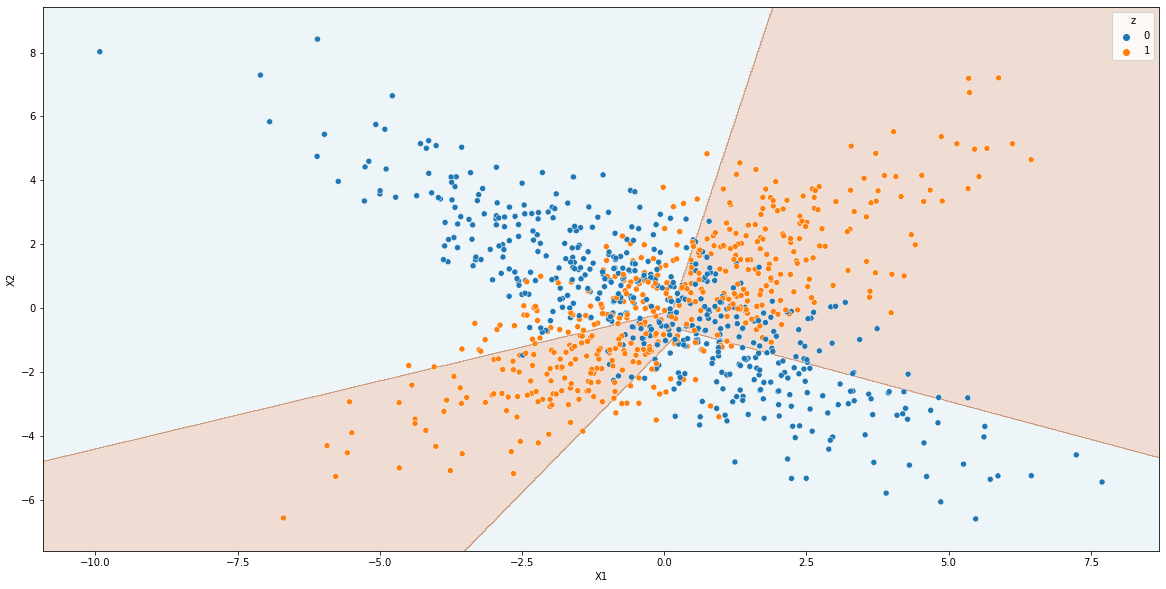

In [15]:
fig, ax = plot_decision_boundary(dataset=df[["X1", "X2"]], labels=np.array([0, 1]), model=test.model)
sns.scatterplot(data=df, x="X1", y="X2", hue="z", ax=ax)
plt.show()

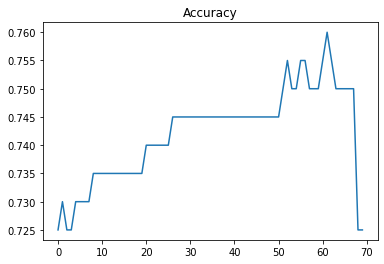

In [16]:
sns.lineplot(x=[i for i in range(len(test.accuracies))], y=test.accuracies).set(title="Accuracy")
plt.show()

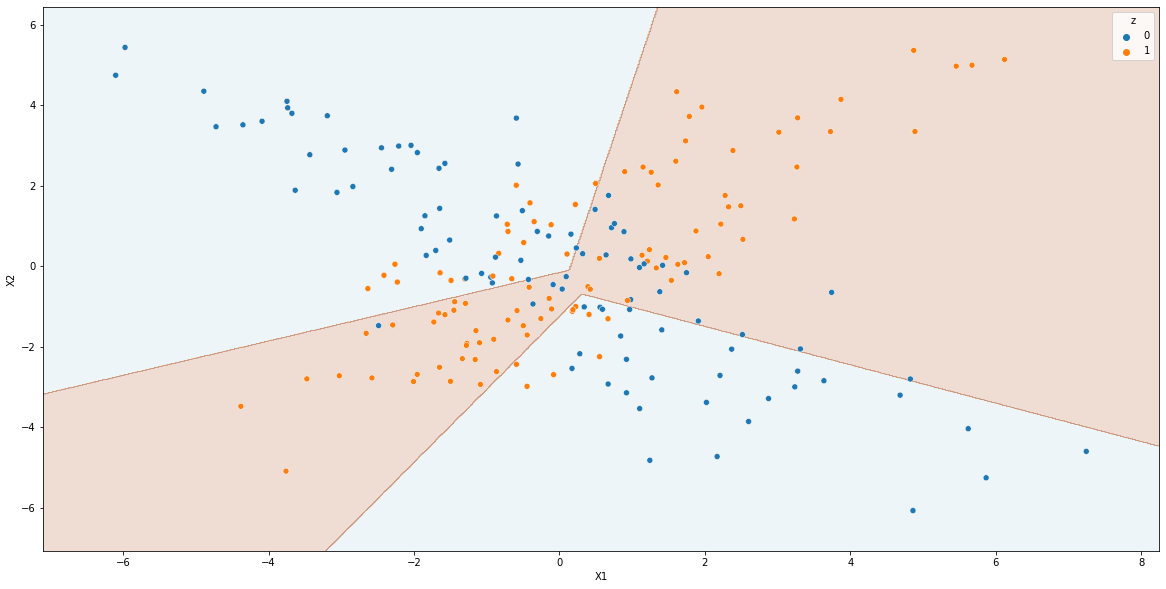

In [17]:
fig, ax = plot_decision_boundary(dataset=X_test, labels=np.array([0, 1]), model=test.model)
sns.scatterplot(data=X_test, x="X1", y="X2", hue=Y_test, ax=ax)
plt.show()

# Second Strategy : with soft labels

In [18]:
class SelfLearningWithSoft():
    def __init__(
        self,
        known_x_train,
        known_y_train,
        unknown_x_train,
        model_convergence_epochs 
    ):
        self.model_convergence_epochs = model_convergence_epochs
        self.model = Simple_Neural_Net()
        self.known_x_train = known_x_train
        self.known_y_train = known_y_train
        self.unknown_x_train = unknown_x_train
        
        self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.2)
        self.accuracies = []
    
    def learning(self, validation_x, validation_y, n_epochs=10):
        for epochs in range(n_epochs):
            self.unknown_x_train["y"] = self.model.predict_probas(self.unknown_x_train.to_numpy()).detach().numpy()
            self.known_x_train = pd.concat(
                [
                    self.known_x_train,
                    self.unknown_x_train[["X1", "X2"]],
                ]
            )
            self.known_y_train = pd.concat(
                [
                    self.known_y_train,
                    self.unknown_x_train["y"],
                ]
            )
            self.unknown_x_train = self.unknown_x_train[["X1", "X2"]]
            predictions = self.model.predict_probas(validation_x.to_numpy()).reshape(-1).detach().numpy().round()
            self.accuracies.append(accuracy_score(validation_y, predictions))
            print(f"Accuracy epochs {epochs}: {accuracy_score(validation_y, predictions)}")
            self.model.fit(
                self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.2, verbose=False, soft=True
            )

In [24]:
test = SelfLearningWithSoft(
    known_x_train=known_train[["X1", "X2"]],
    known_y_train=known_train["z"],
    unknown_x_train=unknow_train[["X1", "X2"]],
    model_convergence_epochs=20
)

Epoch 1/20
8/8 [==============================] - 0s 2ms/step - loss: 0.7176 - accuracy: 0.5750
Epoch 2/20
8/8 [==============================] - 0s 4ms/step - loss: 0.6177 - accuracy: 0.7625
Epoch 3/20
8/8 [==============================] - 0s 2ms/step - loss: 0.5747 - accuracy: 0.8125
Epoch 4/20
8/8 [==============================] - 0s 3ms/step - loss: 0.5450 - accuracy: 0.8000
Epoch 5/20
8/8 [==============================] - 0s 3ms/step - loss: 0.5201 - accuracy: 0.7875
Epoch 6/20
8/8 [==============================] - 0s 3ms/step - loss: 0.4994 - accuracy: 0.8000
Epoch 7/20
8/8 [==============================] - 0s 2ms/step - loss: 0.4823 - accuracy: 0.7875
Epoch 8/20
8/8 [==============================] - 0s 3ms/step - loss: 0.4682 - accuracy: 0.8000
Epoch 9/20
8/8 [==============================] - 0s 3ms/step - loss: 0.4564 - accuracy: 0.8000
Epoch 10/20
8/8 [==============================] - 0s 2ms/step - loss: 0.4474 - accuracy: 0.8000
Epoch 11/20
8/8 [======================

In [25]:
test.learning(validation_x=X_test, validation_y=Y_test, n_epochs=10)

Accuracy epochs 0: 0.77
Accuracy epochs 1: 0.76
Accuracy epochs 2: 0.77
Accuracy epochs 3: 0.77
Accuracy epochs 4: 0.77
Accuracy epochs 5: 0.775
Accuracy epochs 6: 0.775
Accuracy epochs 7: 0.775
Accuracy epochs 8: 0.775
Accuracy epochs 9: 0.775


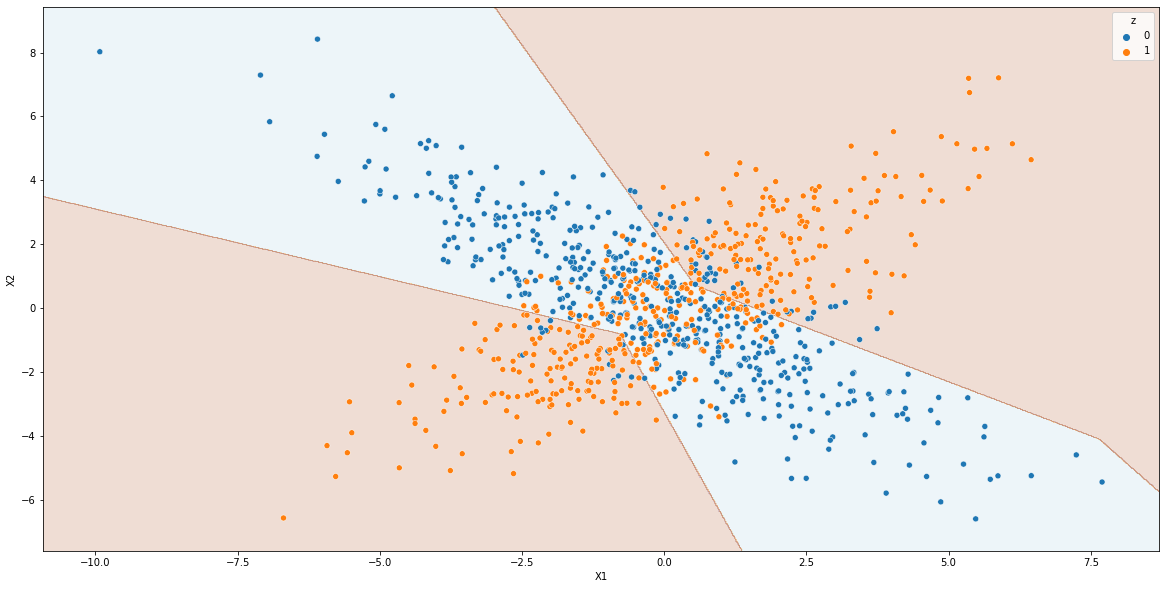

In [26]:
fig, ax = plot_decision_boundary(dataset=df[["X1", "X2"]], labels=np.array([0, 1]), model=test.model)
sns.scatterplot(data=df, x="X1", y="X2", hue="z", ax=ax)
plt.show()

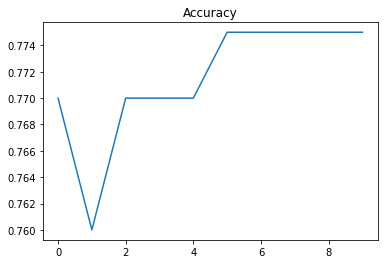

In [27]:
sns.lineplot(x=[i for i in range(len(test.accuracies))], y=test.accuracies).set(title="Accuracy")
plt.show()

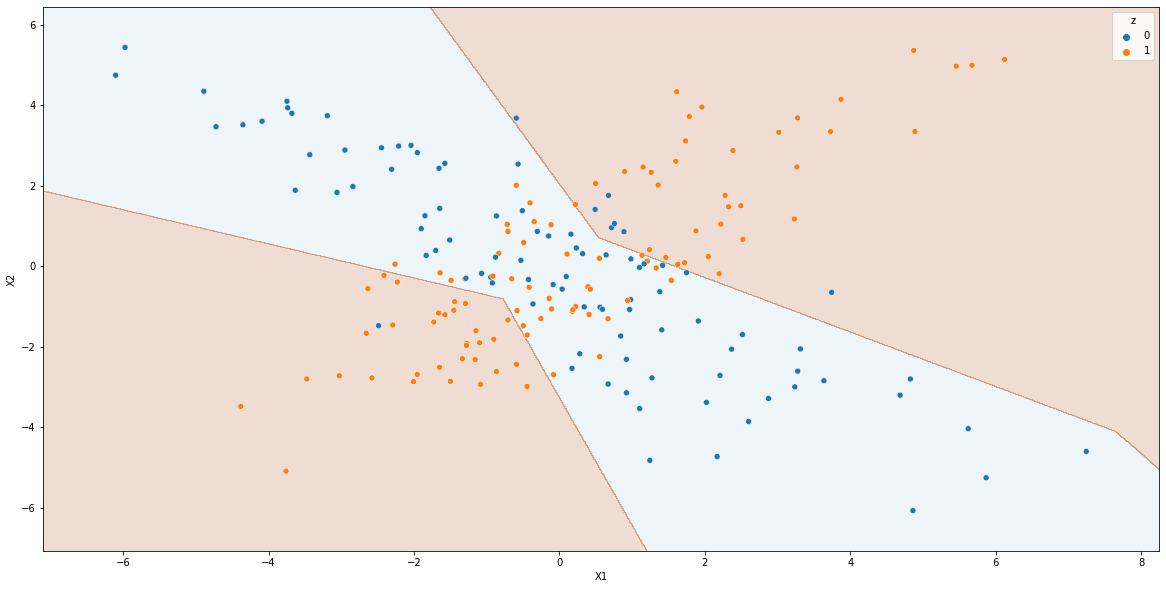

In [28]:
fig, ax = plot_decision_boundary(dataset=X_test, labels=np.array([0, 1]), model=test.model)
sns.scatterplot(data=X_test, x="X1", y="X2", hue=Y_test, ax=ax)
plt.show()